<a href="https://colab.research.google.com/github/chaordichris/KRTH/blob/main/KRTH_Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explanation:

Download Data: Uses the yfinance library to download historical stock data for the specified tickers and date range.

Calculate Returns: Computes the daily returns for each stock using the pct_change() function.

Plotting: Creates three scatter plots and regression lines for the pairs (Fresenius vs Deutsche Bank), (Fresenius vs Commerz Bank), and (Commerz Bank vs Deutsche Bank).

Correlation Calculation: Uses NumPy's corrcoef function to calculate and print the correlation coefficients between Fresenius and Deutsche Bank, and Fresenius and Commerz Bank.

Going to focus solely on repdocing working code in this notebook


[*********************100%***********************]  3 of 3 completed


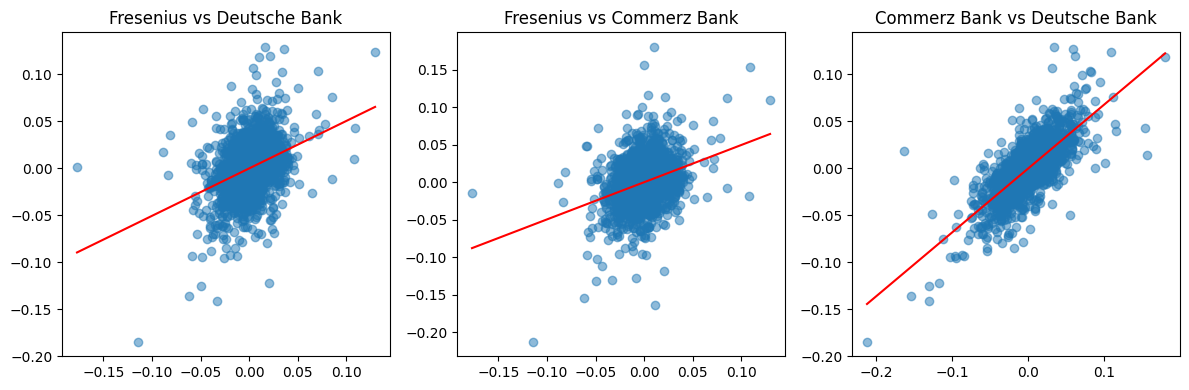

Correlation between Fresenius and Deutsche Bank: 0.35492945525331177
Correlation between Fresenius and Commerz Bank: 0.315157155676815


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # You can use yfinance to download stock data

# Define the list of stock tickers and date range
tickers = ["CBK.DE", "DBK.DE", "FRE.DE"]
start_date = '2013-01-01'
end_date = '2023-04-30'

# Download historical stock data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns for each stock
rets_fresenius = data['FRE.DE'].pct_change().dropna()
rets_deutsche_bank = data['DBK.DE'].pct_change().dropna()
rets_commerz_bank = data['CBK.DE'].pct_change().dropna()

# Plotting
plt.figure(figsize=(12, 4))

# Scatter plot for Fresenius vs Deutsche Bank
plt.subplot(131)
plt.scatter(rets_fresenius, rets_deutsche_bank, alpha=0.5)
plt.plot(np.unique(rets_fresenius), np.poly1d(np.polyfit(rets_fresenius, rets_deutsche_bank, 1))(np.unique(rets_fresenius)), color='red')
plt.title('Fresenius vs Deutsche Bank')

# Scatter plot for Fresenius vs Commerz Bank
plt.subplot(132)
plt.scatter(rets_fresenius, rets_commerz_bank, alpha=0.5)
plt.plot(np.unique(rets_fresenius), np.poly1d(np.polyfit(rets_fresenius, rets_commerz_bank, 1))(np.unique(rets_fresenius)), color='red')
plt.title('Fresenius vs Commerz Bank')

# Scatter plot for Commerz Bank vs Deutsche Bank
plt.subplot(133)
plt.scatter(rets_commerz_bank, rets_deutsche_bank, alpha=0.5)
plt.plot(np.unique(rets_commerz_bank), np.poly1d(np.polyfit(rets_commerz_bank, rets_deutsche_bank, 1))(np.unique(rets_commerz_bank)), color='red')
plt.title('Commerz Bank vs Deutsche Bank')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Calculate and print correlations
correlation_fd = np.corrcoef(rets_fresenius, rets_deutsche_bank)[0, 1]
correlation_fc = np.corrcoef(rets_fresenius, rets_commerz_bank)[0, 1]

print(f'Correlation between Fresenius and Deutsche Bank: {correlation_fd}')
print(f'Correlation between Fresenius and Commerz Bank: {correlation_fc}')



searching for the optimial portfolio of two correlated stocks and one risk-free bond



In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to estimate the matrix of the second mixed
# non-centralized moments of the excess returns
def estimate_sigma(in_sample_returns, risk_free_return):
    n_assets = in_sample_returns.shape[0]
    n_observations = in_sample_returns.shape[1]
    cov_matrix = np.zeros((n_assets, n_assets))

    for k in range(n_assets):
        for j in range(n_assets):
            cov_matrix[k, j] = np.mean((in_sample_returns[k, :] - risk_free_return) * (in_sample_returns[j, :] - risk_free_return))

    return cov_matrix

# Parameters
risk_free_return = 0.02
exp_rets = np.array([0.09, 0.09])
s1 = 0.16
s2 = 0.16
rho = 0.5
cov_mat = np.array([[s1, np.sqrt(s1 * s2) * rho], [np.sqrt(s1 * s2) * rho, s2]])

# To estimate sigma, take a big sample so that the estimate converges to the genuine value
N = 1000
temp = multivariate_normal.rvs(mean=exp_rets, cov=cov_mat, size=N)
sigma = estimate_sigma(temp.T, risk_free_return)

# Optimal portfolio via Nekrasov's formula
u = (1 + risk_free_return) * pinv(sigma) @ (exp_rets - risk_free_return)

# Determine the number of all possible fraction combinations by no short selling
path_len = 100
sim_num = 100
comb_len = 0

for i in range(101):
    for j in range(101 - i):
        comb_len += 1

terminal_wealth = np.zeros((comb_len, 3, sim_num))

# All fractions function
def all_fracs():
    for simulation in range(sim_num):
        rets = multivariate_normal.rvs(mean=exp_rets, cov=cov_mat, size=N).T

        for i in range(path_len):
            for asset in range(2):
                if rets[asset, i] < -0.95:
                    rets[asset, i] = -0.95
                elif rets[asset, i] > 0.95:
                    rets[asset, i] = 0.95

        idx = 0
        for i in range(101):
            for j in range(101 - i):
                frac1 = 0.01 * i
                frac2 = 0.01 * j
                wealth = 1.0
                capital_in_cash = 1.0 - (frac1 + frac2)

                for shritt in range(path_len):
                    wealth *= ((1.0 + rets[0, shritt]) * frac1
                               + (1.0 + rets[1, shritt]) * frac2
                               + 1.02 * capital_in_cash)

                terminal_wealth[idx, 0, simulation] = frac1
                terminal_wealth[idx, 1, simulation] = frac2
                terminal_wealth[idx, 2, simulation] = wealth
                idx += 1

    return terminal_wealth

# Compile the function
all_fracs_compiled = np.vectorize(all_fracs)

# Run the compiled function
terminal_wealth = all_fracs_compiled()

# Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(terminal_wealth[:, 0, 0], terminal_wealth[:, 1, 0], terminal_wealth[:, 2, 0], c='r', marker='o')
# ax.set_xlabel('Fraction 1')
# ax.set_ylabel('Fraction 2')
# ax.set_zlabel('Terminal Wealth')
# plt.show()
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# ... (your previous code)

# Plotting with Plotly
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=terminal_wealth[:, 0, 0],
    y=terminal_wealth[:, 1, 0],
    z=terminal_wealth[:, 2, 0],
    mode='markers',
    marker=dict(
        size=4,
        color='red',
        opacity=0.8
    )
)

fig.add_trace(scatter)

# Layout configuration
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Fraction 1'),
        yaxis=dict(title='Fraction 2'),
        zaxis=dict(title='Terminal Wealth'),
    ),
    scene_camera=dict(
        eye=dict(x=1.86, y=0.61, z=0.98)
    )
)

# Show the interactive chart
fig.show()


# Average among all simulation paths
terminal_wealth_averaged = np.zeros((comb_len, 3, 1))

for i in range(comb_len):
    terminal_wealth_averaged[i, 0, 0] = terminal_wealth[i, 0, 0]
    terminal_wealth_averaged[i, 1, 0] = terminal_wealth[i, 1, 0]
    terminal_wealth_averaged[i, 2, 0] = np.mean(np.log(terminal_wealth[i, 2, :]))

# Compare theoretical and empirical optimal solution
real_max_idx = np.argmax(terminal_wealth_averaged[:, 2, 0])
teor_max_idx = np.where(np.logical_and(
    np.round(terminal_wealth_averaged[:, 0, 0], 2) == np.round(u[0], 2),
    np.round(terminal_wealth_averaged[:, 1, 0], 2) == np.round(u[1], 2)
))

# print("Theoretical optimal solution:")
# print(terminal_wealth_averaged[teor_max_idx, :, 0])

# print("Empirical optimal solution:")
# print(terminal_wealth_averaged[real_max_idx, :, 0])


Sensitivity of the optimal portfolio to the parameeters estimation error

In [3]:
import numpy as np
from numpy.linalg import pinv
from scipy.stats import multivariate_normal
from scipy.stats import mvn

# Parameters
s1 = 0.4
s2 = 0.3
rho = 0.7
mu1 = 0.12
mu2 = 0.09
risk_free_return = 0.01
n_sim = 100

# True market parameters
cov_mat_true = np.array([[s1 * s1, s1 * s2 * rho], [s1 * s2 * rho, s2 * s2]])
sigma_true = np.array([[0.131, 0.067], [0.067, 0.158]])
exp_rets_true = np.array([mu1, mu2])

# Optimal portfolio with true market parameters via Nekrasov's formula
u_true = (1 + risk_free_return) * pinv(sigma_true) @ (exp_rets_true - risk_free_return)
print("Optimal portfolio with TRUE market parameters:")
print(u_true)

# Three trials with a limited sample of "empirical" market data
for trial in range(1, 4):
    historical_data = multivariate_normal.rvs(mean=exp_rets_true, cov=cov_mat_true, size=n_sim).T
    sigma_empirical = np.cov(historical_data)
    print(f"\nWith empirical market parameters - TRIAL {trial}:")
    u_empirical = (1 + risk_free_return) * pinv(sigma_empirical) @ (exp_rets_true - risk_free_return)
    print(u_empirical)


Optimal portfolio with TRUE market parameters:
[0.74897896 0.1937874 ]

With empirical market parameters - TRIAL 1:
[0.57177636 0.35675962]

With empirical market parameters - TRIAL 2:
[0.2580336  0.60764237]

With empirical market parameters - TRIAL 3:
[0.6838895  0.31437928]


Estimation of the correlation matrix of metro AG, Sudzucker AG and silver

In [4]:
import yfinance as yf
import numpy as np

# Download stock data
tickers = ["LLY", "GS", "SLV"]
start_date = "2022-05-01"
end_date = "2023-05-13"
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
rets_meo = stock_data['LLY'].pct_change().dropna().values
rets_szu = stock_data['GS'].pct_change().dropna().values
rets_slv = stock_data['SLV'].pct_change().dropna().values

# Determine the minimum length of returns
n = min(len(rets_meo), len(rets_szu), len(rets_slv))

# Create a matrix to store returns
rets_matrix = np.zeros((n, 3))
rets_matrix[:, 0] = rets_meo[:n]
rets_matrix[:, 1] = rets_szu[:n]
rets_matrix[:, 2] = rets_slv[:n]

# Calculate the correlation matrix
corr_mat = np.corrcoef(rets_matrix, rowvar=False)

# Print the rounded correlation matrix
print(np.round(corr_mat, 2))



[*********************100%***********************]  3 of 3 completed

[[1.   0.25 0.16]
 [0.25 1.   0.26]
 [0.16 0.26 1.  ]]


Looking at the implied drift for LLY

In [5]:
import numpy as np

def implied_drift(buy_price, TP, SL, TP_prob, SL_prob, N_DAYS, Vola):
    target_up = TP / buy_price
    target_down = SL / buy_price
    N_STEPS = 100
    N_SIMULATIONS = 1000
    drifts = np.arange(1, N_STEPS + 1) / 1000
    tp_counts = np.zeros(N_STEPS)
    sl_counts = np.zeros(N_STEPS)
    results_array = np.zeros(N_STEPS)

    for d in range(N_STEPS):
        for i in range(N_SIMULATIONS):
            price = 1.0
            rets = np.random.normal(drifts[d], Vola, N_DAYS)
            for j in range(N_DAYS):
                price *= (1 + rets[j])
                # break and go to the next iteration if SL or TP is reached
                if price >= target_up:
                    tp_counts[d] += 1
                    break
                elif price <= target_down:
                    sl_counts[d] += 1
                    break

        tp_counts[d] /= N_SIMULATIONS
        sl_counts[d] /= N_SIMULATIONS

    results_array = np.abs(tp_counts - TP_prob) + np.abs(sl_counts - SL_prob)
    optimal_drift_id = np.argmin(results_array)

    print(f"Implied drift: {drifts[optimal_drift_id]}")
    print(f"Empirical TP prob: {tp_counts[optimal_drift_id]}")
    print(f"Empirical SL prob: {sl_counts[optimal_drift_id]}")

# Test the function
implied_drift(29.79, 35.4, 26.4, 0.5, 0.5, 141, 0.01883767)


Implied drift: 0.001
Empirical TP prob: 0.509
Empirical SL prob: 0.386


an old portfolio of LLY and GS

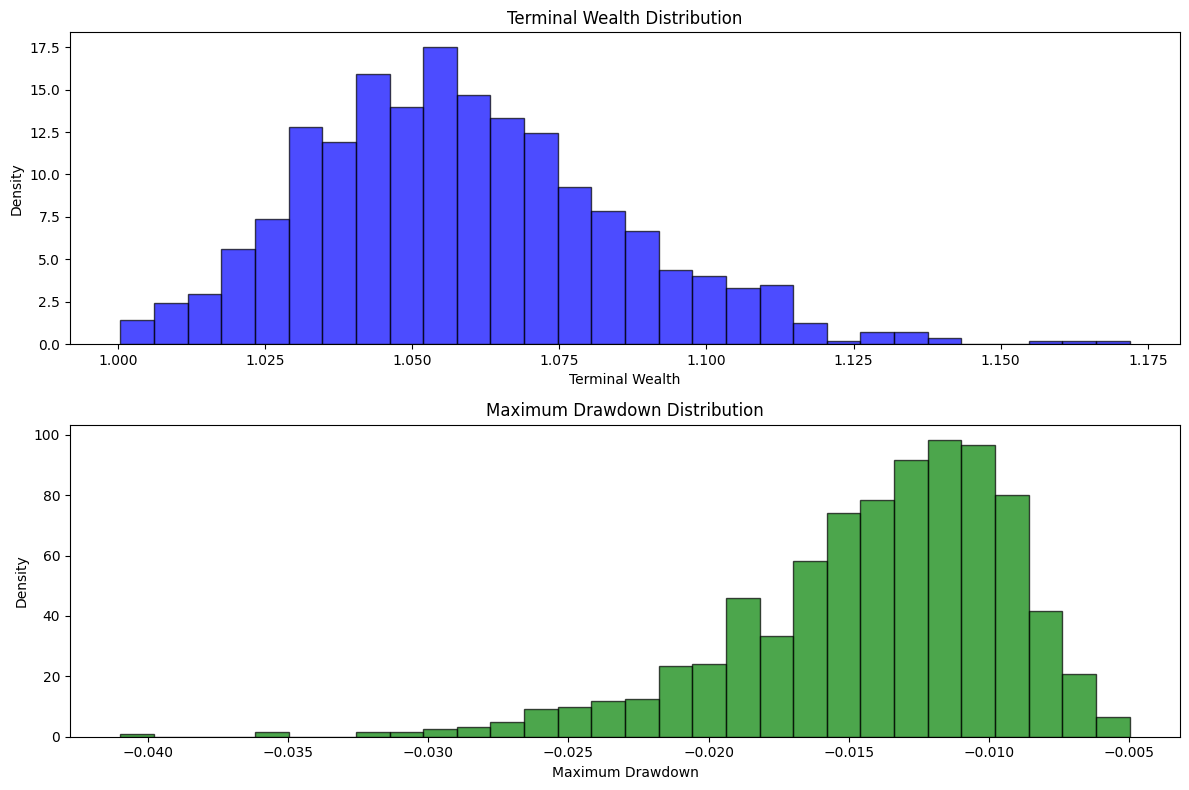

Mean Terminal Wealth: 1.058538742797909
Standard Deviation Terminal Wealth: 0.026097568249803565
Mean Maximum Drawdown: -0.014060082517471675
Standard Deviation Maximum Drawdown: 0.004855178123828391


In [6]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Function to calculate maximum drawdown
def max_drawdown(wealth_path):
    cummax = np.maximum.accumulate(wealth_path)
    drawdown = (wealth_path - cummax) / cummax
    return np.min(drawdown)

# Set random seed for reproducibility
np.random.seed(42)

# Calculate implied drifts
drift_MEO = 0.007
drift_SZU = 0.003
implied_drifts = np.array([drift_MEO, drift_SZU])

# Calculate covariance matrix
vola_MEO = np.std(rets_meo[:n])
vola_SZU = np.std(rets_szu[:n])
rho = np.corrcoef(rets_szu[:n], rets_meo[:n])[0, 1]
covar = vola_MEO * vola_SZU * rho
cov_matrix = np.array([[vola_MEO**2, covar], [covar, vola_SZU**2]])

# Simulation parameters
N_DAYS = 121
N_SIMULATIONS = 1000
start_wealth_MEO = 0.1 * 29.35 / 29.79
start_wealth_SZU = 0.1 * 15.7 / 16.1
wealth_MEO = np.full((N_DAYS, N_SIMULATIONS), start_wealth_MEO)
wealth_SZU = np.full((N_DAYS, N_SIMULATIONS), start_wealth_SZU)
wealth_cash = np.full((N_DAYS, N_SIMULATIONS), 0.8)
max_dd_path = np.zeros(N_SIMULATIONS)
tp_MEO = 0.1 * (35.4 / 29.79)
sl_MEO = 0.1 * (26.4 / 29.79)

# Simulation loop
for i in range(N_SIMULATIONS):
    m_rets = multivariate_normal.rvs(mean=implied_drifts, cov=cov_matrix, size=N_DAYS)
    for d in range(1, N_DAYS):
        wealth_MEO[d, i] = wealth_MEO[d - 1, i] * (1 + m_rets[d, 0])
        wealth_SZU[d, i] = wealth_SZU[d - 1, i] * (1 + m_rets[d, 1])
        if wealth_MEO[d, i] >= tp_MEO or wealth_MEO[d, i] < sl_MEO:
            wealth_cash[d:, i] += wealth_MEO[d, i]
            wealth_MEO[d:, i] = 0.0

    path_wealth = wealth_cash[:, i] + wealth_MEO[:, i] + wealth_SZU[:, i]
    max_dd_path[i] = max_drawdown(path_wealth)

total_wealth = wealth_cash + wealth_MEO + wealth_SZU
terminal_wealth = total_wealth[-1, :]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title("Terminal Wealth Distribution")
plt.hist(terminal_wealth, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Terminal Wealth")
plt.ylabel("Density")

plt.subplot(2, 1, 2)
plt.title("Maximum Drawdown Distribution")
plt.hist(max_dd_path, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Maximum Drawdown")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean Terminal Wealth: {np.mean(terminal_wealth)}")
print(f"Standard Deviation Terminal Wealth: {np.std(terminal_wealth)}")
print(f"Mean Maximum Drawdown: {np.mean(max_dd_path)}")
print(f"Standard Deviation Maximum Drawdown: {np.std(max_dd_path)}")


New portfolio of MEO + SZU + SLV

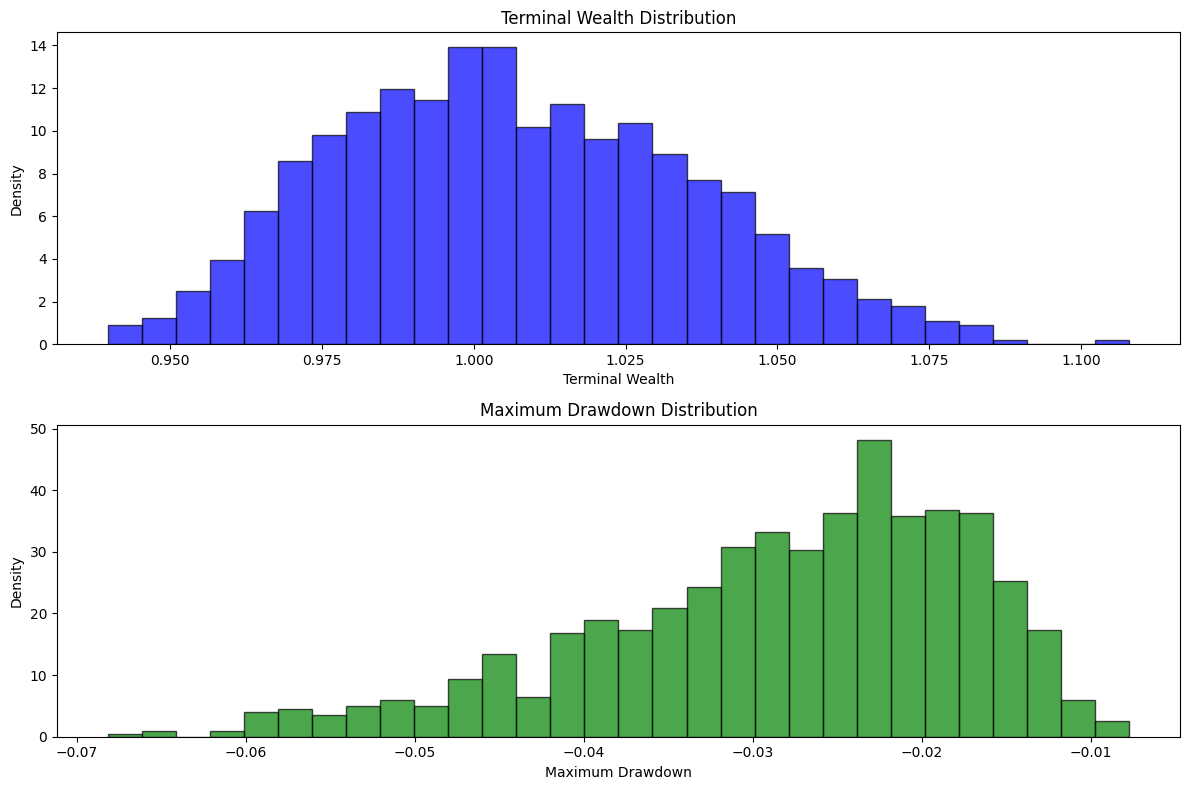

Mean Terminal Wealth: 1.0069721680350006
Standard Deviation Terminal Wealth: 0.02921627592635149
Mean Maximum Drawdown: -0.02828883284602504
Standard Deviation Maximum Drawdown: 0.01108660157456637


In [7]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Function to calculate maximum drawdown
def max_drawdown(wealth_path):
    cummax = np.maximum.accumulate(wealth_path)
    drawdown = (wealth_path - cummax) / cummax
    return np.min(drawdown)

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
drift_MEO = 0.0007
drift_SZU = 0.0003
drift_SLV = 0.0015
implied_drifts = np.array([drift_MEO, drift_SZU, drift_SLV])
cov_matrix = np.cov(rets_matrix, rowvar=False)

# Simulation parameters
N_DAYS = 121
N_SIMULATIONS = 1000
start_wealth_MEO = 0.1 * 29.35 / 29.79
start_wealth_SZU = 0.1 * 15.70 / 16.1
wealth_MEO = np.full((N_DAYS, N_SIMULATIONS), start_wealth_MEO)
wealth_SZU = np.full((N_DAYS, N_SIMULATIONS), start_wealth_SZU)
wealth_SLV = np.full((N_DAYS, N_SIMULATIONS), 0.1)
wealth_cash = np.full((N_DAYS, N_SIMULATIONS), 0.7)
max_dd_path = np.zeros(N_SIMULATIONS)
tp_MEO = 0.1 * (35.4 / 29.79)
sl_MEO = 0.1 * (26.4 / 29.79)
tp_SLV = 0.1 * (22.0 / 19.4)
sl_SLV = 0.1 * (18.4 / 19.4)

# Simulation loop
for i in range(N_SIMULATIONS):
    m_rets = multivariate_normal.rvs(mean=implied_drifts, cov=cov_matrix, size=N_DAYS)
    for d in range(1, N_DAYS):
        wealth_MEO[d, i] = wealth_MEO[d - 1, i] * (1 + m_rets[d, 0])
        wealth_SZU[d, i] = wealth_SZU[d - 1, i] * (1 + m_rets[d, 1])
        wealth_SLV[d, i] = wealth_SLV[d - 1, i] * (1 + m_rets[d, 2])

        if wealth_MEO[d, i] >= tp_MEO or wealth_MEO[d, i] < sl_MEO:
            wealth_cash[d:, i] += wealth_MEO[d, i]
            wealth_MEO[d:, i] = 0.0

        if wealth_SLV[d, i] >= tp_SLV or wealth_SLV[d, i] < sl_SLV:
            wealth_cash[d:, i] += wealth_SLV[d, i]
            wealth_SLV[d:, i] = 0.0

    path_wealth = wealth_cash[:, i] + wealth_MEO[:, i] + wealth_SZU[:, i] + wealth_SLV[:, i]
    max_dd_path[i] = max_drawdown(path_wealth)

total_wealth = wealth_cash + wealth_MEO + wealth_SZU + wealth_SLV
terminal_wealth = total_wealth[-1, :]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title("Terminal Wealth Distribution")
plt.hist(terminal_wealth, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Terminal Wealth")
plt.ylabel("Density")

plt.subplot(2, 1, 2)
plt.title("Maximum Drawdown Distribution")
plt.hist(max_dd_path, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Maximum Drawdown")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean Terminal Wealth: {np.mean(terminal_wealth)}")
print(f"Standard Deviation Terminal Wealth: {np.std(terminal_wealth)}")
print(f"Mean Maximum Drawdown: {np.mean(max_dd_path)}")
print(f"Standard Deviation Maximum Drawdown: {np.std(max_dd_path)}")
